<a href="https://colab.research.google.com/github/shiweijing/Coursera_Capstone/blob/master/Toronto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Neighborhoods in Toronto**

**PART 1**

import the Toronto neighborhoods information from WIKIPEDIA page into pandas data frame format


In [32]:
import numpy as np
import pandas as pd

import json
import requests
from sklearn.cluster import KMeans

import folium

import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

from geopy.geocoders import Nominatim

In [2]:
#import Neighbour of Toronto from WIKIPEDIA website
tables = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
print(tables[0])

    Postal Code  ...                                      Neighbourhood
0           M1A  ...                                       Not assigned
1           M2A  ...                                       Not assigned
2           M3A  ...                                          Parkwoods
3           M4A  ...                                   Victoria Village
4           M5A  ...                          Regent Park, Harbourfront
..          ...  ...                                                ...
175         M5Z  ...                                       Not assigned
176         M6Z  ...                                       Not assigned
177         M7Z  ...                                       Not assigned
178         M8Z  ...  Mimico NW, The Queensway West, South of Bloor,...
179         M9Z  ...                                       Not assigned

[180 rows x 3 columns]


In [3]:
#remove rows with borough = Not assigned
df=tables[0]
df.head()
df=df[df['Borough']!='Not assigned']
df=df.rename(columns={"Neighbourhood": "Neighborhood"}) #rename column name Neighbourhood to Neighborhood
print(df)

    Postal Code  ...                                       Neighborhood
2           M3A  ...                                          Parkwoods
3           M4A  ...                                   Victoria Village
4           M5A  ...                          Regent Park, Harbourfront
5           M6A  ...                   Lawrence Manor, Lawrence Heights
6           M7A  ...        Queen's Park, Ontario Provincial Government
..          ...  ...                                                ...
160         M8X  ...      The Kingsway, Montgomery Road, Old Mill North
165         M4Y  ...                               Church and Wellesley
168         M7Y  ...  Business reply mail Processing Centre, South C...
169         M8Y  ...  Old Mill South, King's Mill Park, Sunnylea, Hu...
178         M8Z  ...  Mimico NW, The Queensway West, South of Bloor,...

[103 rows x 3 columns]


In [4]:
#check if there is cell where neighbourhood is not assigned
df[df['Neighborhood']=='Not assigned']

,Postal Code,Borough,Neighborhood


print the shape of the dataframe

In [5]:
df.shape

(103, 3)

**PART 2**

Add the latitude and longitude information to the current dataframe from the csv file by given URL.

initial trial with Geocoding API : get the latitude and longitude coordinates from Google Maps Geocoding API

In [6]:
!pip install geocoder
import geocoder # import geocoder


tried to use GEOCODER API to fetch the coordinates but did not succeeded, so will use the CSV file instead.

In [7]:
# initialize your variable to None
#lat_lng_coords = None

# loop until you get the coordinates
#while(lat_lng_coords is None):
  #g = geocoder.google('{}, Toronto, Ontario'.format('M5G'))
  #lat_lng_coords = g.latlng

#latitude = lat_lng_coords[0]
#longitude = lat_lng_coords[1]

import the coordinates from url/ csv file

In [8]:
url='http://cocl.us/Geospatial_data'
df_geo=pd.read_csv(url)
df_geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


add the coordinates info to the original data frame by using merge method

In [9]:
df_toronto=df.merge(df_geo,on='Postal Code')
print(df_toronto.shape)
df_toronto.head()

(103, 5)


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


**PART 3**
explore and cluster the neighborhoods in Toronto

In [10]:
#keep only Boroughs that contain 'Toronto'
df_toronto=df_toronto[df_toronto['Borough'].str.contains('Toronto')]
df_toronto.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031


split the Neighbourhood column by comma to achieve 1 row for 1 Neighbourhood

In [11]:
df1=df_toronto.set_index(['Postal Code','Borough','Latitude','Longitude'])

df1=df1.Neighborhood.str.split(',')
df1=df1.explode()
df1=df1.reset_index()
df1.head()

,Postal Code,Borough,Latitude,Longitude,Neighborhood
0,M5A,Downtown Toronto,43.654260,-79.360636,Regent Park
1,M5A,Downtown Toronto,43.654260,-79.360636,Harbourfront
2,M7A,Downtown Toronto,43.662301,-79.389494,Queen's Park
3,M7A,Downtown Toronto,43.662301,-79.389494,Ontario Provincial Government
4,M5B,Downtown Toronto,43.657162,-79.378937,Garden District


In [12]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df1['Borough'].unique()),
        df1.shape[0]
    )
)

The dataframe has 4 boroughs and 78 neighborhoods.


get the coordinates of Toronto

In [13]:
address = 'Toronto'

geolocator = Nominatim(user_agent="TO_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


create a map of Toronto with neighbourhoods superimposed on top

In [14]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df1['Latitude'], df1['Longitude'], df1['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Define foursquare Credentials and Version

In [15]:
CLIENT_ID = 'XC5WDSHXZRLRS0MALJXUFXLSUL5NFDAHKKAJ2R1X00UCRDYZ' # your Foursquare ID
CLIENT_SECRET = 'VK1UUDGYHC3ZM2RJXRPKWP1D1CQHHILVREWTZWSO3MUX4DNY' # your Foursquare Secret
VERSION = '20200728' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XC5WDSHXZRLRS0MALJXUFXLSUL5NFDAHKKAJ2R1X00UCRDYZ
CLIENT_SECRET:VK1UUDGYHC3ZM2RJXRPKWP1D1CQHHILVREWTZWSO3MUX4DNY


In [16]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

define a function to fetch the Venue of Neighbourhood from Foursquare

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
toronto_venues=getNearbyVenues(names=df1['Neighborhood'],
                                   latitudes=df1['Latitude'],
                                   longitudes=df1['Longitude']
                                  )

Regent Park
 Harbourfront
Queen's Park
 Ontario Provincial Government
Garden District
 Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond
 Adelaide
 King
Dufferin
 Dovercourt Village
Harbourfront East
 Union Station
 Toronto Islands
Little Portugal
 Trinity
The Danforth West
 Riverdale
Toronto Dominion Centre
 Design Exchange
Brockton
 Parkdale Village
 Exhibition Place
India Bazaar
 The Beaches West
Commerce Court
 Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
 Forest Hill Road Park
High Park
 The Junction South
North Toronto West
 Lawrence Park
The Annex
 North Midtown
 Yorkville
Parkdale
 Roncesvalles
Davisville
University of Toronto
 Harbord
Runnymede
 Swansea
Moore Park
 Summerhill East
Kensington Market
 Chinatown
 Grange Park
Summerhill West
 Rathnelly
 South Hill
 Forest Hill SE
 Deer Park
CN Tower
 King and Spadina
 Railway Lands
 Harbourfront West
 Bathurst Quay
 South Niagara
 Island airport
R

In [19]:
toronto_venues.head(20)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Regent Park,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,Regent Park,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,Regent Park,43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,Regent Park,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,Regent Park,43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
5,Regent Park,43.65426,-79.360636,Corktown Common,43.655618,-79.356211,Park
6,Regent Park,43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
7,Regent Park,43.65426,-79.360636,The Extension Room,43.653313,-79.359725,Gym / Fitness Center
8,Regent Park,43.65426,-79.360636,The Distillery Historic District,43.650244,-79.359323,Historic Site
9,Regent Park,43.65426,-79.360636,Dominion Pub and Kitchen,43.656919,-79.358967,Pub


size of the dataframe

In [20]:
toronto_venues.shape

(3236, 7)

how many venues are returned for each neighbourhood

In [21]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adelaide,100,100,100,100,100,100
Bathurst Quay,16,16,16,16,16,16
Cabbagetown,45,45,45,45,45,45
Chinatown,65,65,65,65,65,65
Deer Park,17,17,17,17,17,17
...,...,...,...,...,...,...
The Annex,22,22,22,22,22,22
The Beaches,4,4,4,4,4,4
The Danforth West,42,42,42,42,42,42


unique categories

In [22]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 235 uniques categories.


perform one hot encoding for venue category

In [23]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['NB'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot[toronto_onehot['NB']=='Regent Park']

,NB,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,...,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Regent Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Regent Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Regent Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Regent Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Regent Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Regent Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Regent Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Regent Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Regent Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Regent Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
toronto_onehot.shape

(3236, 236)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [25]:
toronto_grouped = toronto_onehot.groupby('NB').mean().reset_index()
toronto_grouped[toronto_grouped['NB']=='Regent Park']

,NB,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,...,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
63,Regent Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021739,0.0,0.021739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.065217,0.021739,0.0,0.0,0.0,0.0,0.0,0.0,0.021739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.0,0.0,0.0,...,0.021739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021739,0.0,0.021739


explore the dataframe to get the top 5 most frequent categories for each neighborhood

In [26]:
num_top_venues = 5

for hood in toronto_grouped['NB']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['NB'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Adelaide----
            venue  freq
0     Coffee Shop  0.09
1            Café  0.05
2      Restaurant  0.04
3           Hotel  0.04
4  Clothing Store  0.04


---- Bathurst Quay----
              venue  freq
0   Airport Service  0.19
1    Airport Lounge  0.12
2  Airport Terminal  0.12
3             Plane  0.06
4           Airport  0.06


---- Cabbagetown----
         venue  freq
0  Coffee Shop  0.09
1         Café  0.07
2  Pizza Place  0.07
3   Restaurant  0.04
4          Pub  0.04


---- Chinatown----
                           venue  freq
0                           Café  0.08
1                    Coffee Shop  0.06
2  Vegetarian / Vegan Restaurant  0.06
3             Mexican Restaurant  0.05
4                            Bar  0.05


---- Deer Park----
                 venue  freq
0                  Pub  0.12
1          Coffee Shop  0.12
2   Light Rail Station  0.06
3          Supermarket  0.06
4  Fried Chicken Joint  0.06


---- Design Exchange----
                venue  freq
0  

In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [28]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['NB']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(77)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Coffee Shop,Café,Restaurant,Clothing Store,Hotel,Thai Restaurant,Bar,Steakhouse,Gym,American Restaurant
1,Bathurst Quay,Airport Service,Airport Lounge,Airport Terminal,Boutique,Airport,Airport Food Court,Airport Gate,Harbor / Marina,Rental Car Location,Sculpture Garden
2,Cabbagetown,Coffee Shop,Pizza Place,Café,Restaurant,Park,Italian Restaurant,Bakery,Chinese Restaurant,Pub,Gastropub
3,Chinatown,Café,Coffee Shop,Vegetarian / Vegan Restaurant,Dessert Shop,Mexican Restaurant,Vietnamese Restaurant,Bar,Gaming Cafe,Grocery Store,Burger Joint
4,Deer Park,Pub,Coffee Shop,Fried Chicken Joint,Liquor Store,Sandwich Place,Restaurant,Sports Bar,Bank,Supermarket,Sushi Restaurant
...,...,...,...,...,...,...,...,...,...,...,...
72,The Annex,Sandwich Place,Café,Coffee Shop,Pub,History Museum,Burger Joint,Middle Eastern Restaurant,Flower Shop,Indian Restaurant,Donut Shop
73,The Beaches,Trail,Neighborhood,Health Food Store,Pub,Dog Run,Dessert Shop,Diner,Discount Store,Distribution Center,Yoga Studio
74,The Danforth West,Greek Restaurant,Italian Restaurant,Coffee Shop,Restaurant,Ice Cream Shop,Furniture / Home Store,Indian Restaurant,Pub,Spa,Caribbean Restaurant
75,Toronto Dominion Centre,Coffee Shop,Hotel,Café,Restaurant,Japanese Restaurant,Italian Restaurant,American Restaurant,Salad Place,Seafood Restaurant,Deli / Bodega


**clustering**

In [30]:
toronto_grouped_clustering = toronto_grouped.drop('NB', 1)
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k,random_state=0).fit(toronto_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)



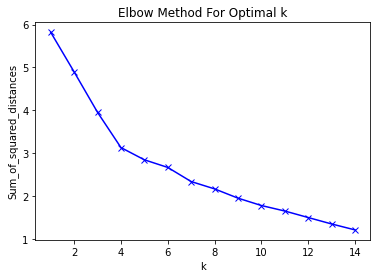

In [33]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

the optimal K (elbow point is 4)

In [34]:
# set number of clusters
kclusters = 4

#toronto_grouped_clustering = toronto_grouped.drop('NB', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 0, 0, 0, 0, 0, 0, 3, 0], dtype=int32)

In [35]:
# add clustering labels

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df1

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.shape

(78, 16)

In [36]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]

colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

let's go through all the clusters to find the insignt behind

Cluster 1

In [37]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,0,Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Café,Theater,Mexican Restaurant,Shoe Store,Restaurant
1,Downtown Toronto,0,Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Café,Theater,Mexican Restaurant,Shoe Store,Restaurant
2,Downtown Toronto,0,Coffee Shop,Diner,Yoga Studio,Creperie,Park,Music Venue,Mexican Restaurant,Italian Restaurant,Hobby Shop,Fried Chicken Joint
3,Downtown Toronto,0,Coffee Shop,Diner,Yoga Studio,Creperie,Park,Music Venue,Mexican Restaurant,Italian Restaurant,Hobby Shop,Fried Chicken Joint
4,Downtown Toronto,0,Coffee Shop,Clothing Store,Bubble Tea Shop,Café,Cosmetics Shop,Japanese Restaurant,Italian Restaurant,Lingerie Store,Fast Food Restaurant,Bookstore
...,...,...,...,...,...,...,...,...,...,...,...,...
73,Downtown Toronto,0,Coffee Shop,Café,Hotel,Gym,Restaurant,Japanese Restaurant,American Restaurant,Seafood Restaurant,Steakhouse,Deli / Bodega
74,Downtown Toronto,0,Coffee Shop,Café,Hotel,Gym,Restaurant,Japanese Restaurant,American Restaurant,Seafood Restaurant,Steakhouse,Deli / Bodega
75,Downtown Toronto,0,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Gay Bar,Restaurant,Men's Store,Hotel,Café,Yoga Studio,Bubble Tea Shop
76,East Toronto,0,Light Rail Station,Skate Park,Burrito Place,Auto Workshop,Farmers Market,Spa,Garden,Garden Center,Restaurant,Pizza Place


cluster 2

In [38]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
34,Central Toronto,1,Garden,Yoga Studio,Deli / Bodega,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run


cluster 3

In [39]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
62,Downtown Toronto,2,Airport Service,Airport Lounge,Airport Terminal,Boutique,Airport,Airport Food Court,Airport Gate,Harbor / Marina,Rental Car Location,Sculpture Garden
63,Downtown Toronto,2,Airport Service,Airport Lounge,Airport Terminal,Boutique,Airport,Airport Food Court,Airport Gate,Harbor / Marina,Rental Car Location,Sculpture Garden
64,Downtown Toronto,2,Airport Service,Airport Lounge,Airport Terminal,Boutique,Airport,Airport Food Court,Airport Gate,Harbor / Marina,Rental Car Location,Sculpture Garden
65,Downtown Toronto,2,Airport Service,Airport Lounge,Airport Terminal,Boutique,Airport,Airport Food Court,Airport Gate,Harbor / Marina,Rental Car Location,Sculpture Garden
66,Downtown Toronto,2,Airport Service,Airport Lounge,Airport Terminal,Boutique,Airport,Airport Food Court,Airport Gate,Harbor / Marina,Rental Car Location,Sculpture Garden
67,Downtown Toronto,2,Airport Service,Airport Lounge,Airport Terminal,Boutique,Airport,Airport Food Court,Airport Gate,Harbor / Marina,Rental Car Location,Sculpture Garden
68,Downtown Toronto,2,Airport Service,Airport Lounge,Airport Terminal,Boutique,Airport,Airport Food Court,Airport Gate,Harbor / Marina,Rental Car Location,Sculpture Garden


cluster 4

In [40]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Central Toronto,3,Park,Swim School,Bus Line,Yoga Studio,Department Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
36,Central Toronto,3,Park,Jewelry Store,Trail,Sushi Restaurant,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
37,Central Toronto,3,Park,Jewelry Store,Trail,Sushi Restaurant,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
52,Central Toronto,3,Park,Trail,Tennis Court,Restaurant,Colombian Restaurant,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
53,Central Toronto,3,Park,Trail,Tennis Court,Restaurant,Colombian Restaurant,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
69,Downtown Toronto,3,Park,Playground,Trail,Dance Studio,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
